# Exploring possibilities with `topojson`
Going to take a look at whether it is possible to make a topological data structure backing the tilings. Steps involved:

+ Initial exploration of converting a TileUnit to a `topojson` object and back again (i.e. retrieve the points, edges, faces) - DONE at 27/11/23
+ Look into shapely's new precision options - and generally rationalise the various hacks for keeping polygons clean - DONE 15/12/23 (keep an eye on it for errors, of course...)
+ Build said data structure from clean polgons
+ Explore 'wobbly' edge use-case

In [1]:
%matplotlib inline

import matplotlib.pyplot as pyplot

import geopandas as gpd
import shapely.geometry as geom
import shapely.affinity as affine

from weavingspace import Topology
from weavingspace import TileShape
from weavingspace import TileUnit
from weavingspace import WeaveUnit
from weavingspace import Symmetries
from weavingspace import tiling_utils

In [2]:
square = tiling_utils.get_regular_polygon(200, 4)
L_shape = square.union(
  affine.translate(square, 200, 0)).union(
  affine.translate(square, 0, 200))
# L_shape = tiling_utils.get_clean_polygon(L_shape)

tile = TileUnit()
tile.base_shape = TileShape.HEXAGON
tile.tiles = gpd.GeoDataFrame(
  {"tile_id": list("abcd")},
  geometry = gpd.GeoSeries([affine.translate(L_shape, -100, 200), 
                            affine.translate(L_shape, 100, -200),
                            affine.translate(L_shape, -100, -400), 
                            affine.translate(L_shape, -300, 0)]))
tile.setup_regularised_prototile_from_tiles()
tile.prototile = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(
    geom.Polygon([(100, -450), (-300, -350), (-300, 350),
                  (-100, 450), (300, 350), (300, -350)])))
tile.vectors = tile.get_vectors()
# tile = tile.transform_rotate(90)

<Axes: >

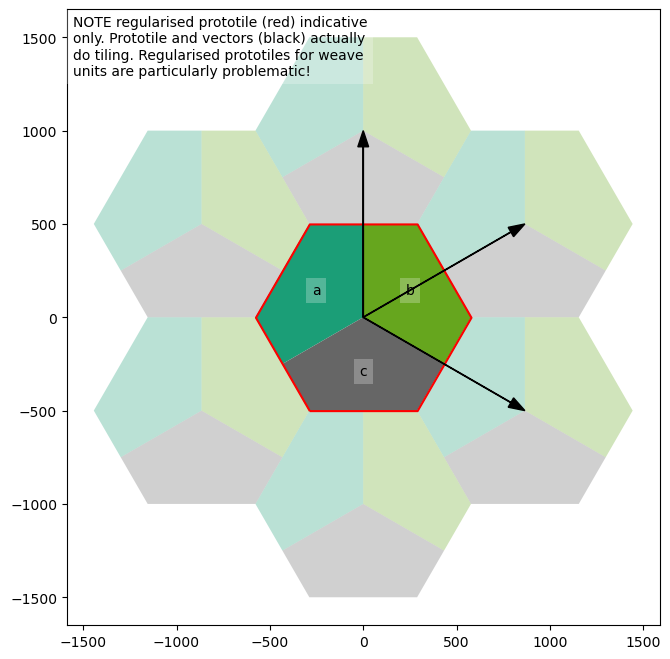

In [3]:
# tile = TileUnit(tiling_type = "archimedean", code = "3.3.4.3.4")
tile = TileUnit(tiling_type = "hex-dissection", n = 3, 
                dissection_offset = 1)
# tile = TileUnit(tiling_type = "cairo", n = 3)
tile.plot(r = 1, show_vectors = True)

In [4]:
print(tile.tiles.geometry[0])

POLYGON ((-577.350269 0, -288.675135 500, 0 500, 0 0, -433.012702 -250, -577.350269 0))


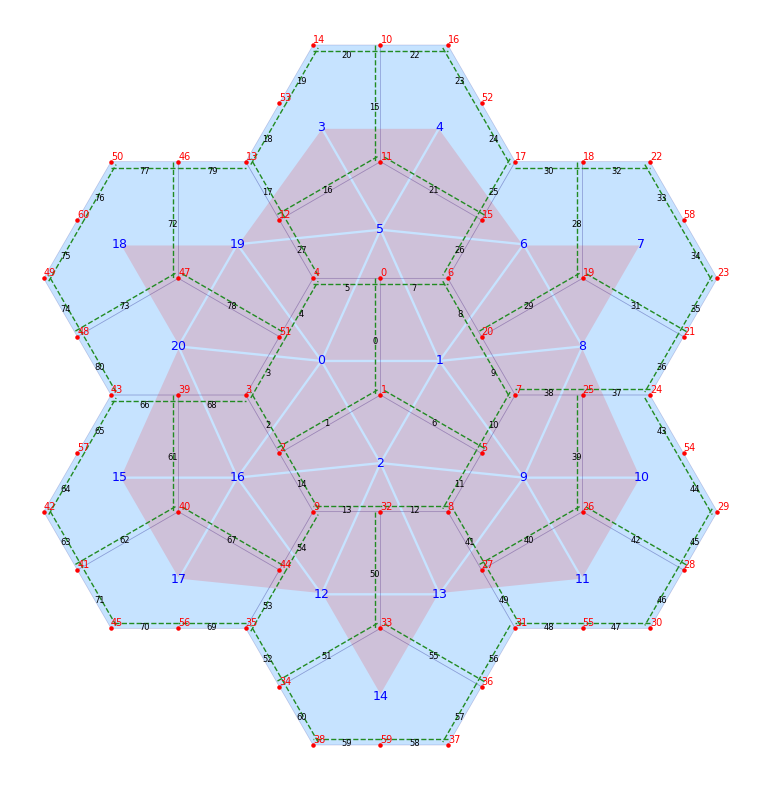

In [5]:
topo = Topology(tile)
ax = topo.plot(
  show_tile_vertex_labels = False,
  show_tile_centres = True,
  show_vertex_ids = True,
  show_vertex_labels = True,
  show_edge_ids = True,
  show_edge_corners = False, 
  show_edges = True,
  offset_edges = True,
  show_vertices = False, 
  show_dual_tiles = True
)

In [6]:
len(topo.is_vertex)

61